# RMIA Implementation and Experiment

This notebook implements the **Ratio Membership Inference Attack (RMIA)** as described in the paper ["Low-Cost High-Power Membership Inference Attacks"](https://arxiv.org/html/2312.03262v3#S2).

## 1. Concept and Objective
**Objective**: To determine whether a specific data point (an image $x$ from CIFAR-10) was part of the training set of a target model (ResNet-18).

**Key Idea**: RMIA improves upon simple loss-based attacks by using a **Likelihood Ratio (LR)** test. It compares the probability of the data under the target model against its probability under a "reference" model (which represents the general population or "world" distribution).

### Core Formulas
1.  **Likelihood Ratio (LR)**:
    $$
    LR(x) = \frac{P(x | \theta_{target})}{P(x | \theta_{ref})}
    $$
    Where:
    *   $P(x | \theta_{target})$ is the confidence of the target model on the true class of $x$.
    *   $P(x | \theta_{ref})$ is the confidence of the reference model (trained on disjoint data) on $x$.

2.  **RMIA Score**:
    The attack doesn't just look at the raw LR. It checks how "exceptional" the LR of $x$ is compared to the LRs of random samples $z$ from the population.
    $$
    Score_{RMIA}(x) = P_{z \sim \mathcal{Z}}(LR(x) > LR(z))
    $$
    This is empirically calculated as the fraction of population samples $z$ that have a lower Likelihood Ratio than $x$ (i.e., the percentile rank).

## 2. Implementation Steps
1.  **Data Preparation**: Split CIFAR-10 into four disjoint sets:
    *   **Target Members (12.5k)**: Used to train the Target Model.
    *   **Reference Members (12.5k)**: Used to train the Reference Model.
    *   **Population $Z$ (12.5k)**: Used to compute the normalization statistics for the RMIA score.
    *   **Non-Members**: The official CIFAR-10 test set, used as the "ground truth" non-members for evaluation.

2.  **Model Training**:
    *   Define a ResNet-18 modified for CIFAR-10 (small kernel size, no initial maxpool).
    *   Train `Target Model` on Target Members.
    *   Train `Reference Model` on Reference Members.
    *   *Note: Weights are saved/loaded to avoid re-training.*

3.  **Attack Execution**:
    *   Compute prediction confidence (probability of true class) for all datasets on both models.
    *   Calculate Likelihood Ratios $LR(x)$ and $LR(z)$.
    *   Compute RMIA Scores by ranking $LR(x)$ against the distribution of $LR(z)$.

4.  **Evaluation**:
    *   Compute the Receiver Operating Characteristic (ROC) curve.
    *   Calculate Area Under the Curve (AUC) to measure attack performance (0.5 = random, 1.0 = perfect).

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import os
import copy
import argparse


In [12]:
# --- 1. Model Definition (ResNet-18 adapted for CIFAR-10) ---
# Standard ResNet18 is designed for ImageNet (224x224).
# For CIFAR-10 (32x32), we need to adjust the initial layers to avoid excessive downsampling.

def get_resnet18_cifar10(num_classes=10):
    # Load standard ResNet18
    model = torchvision.models.resnet18(weights=None)
    
    # Modify the first convolution layer
    # Original: nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
    # CIFAR-10: Kernel size 3, stride 1, padding 1 is better to preserve spatial dim
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    
    # Remove the first MaxPool layer
    # Original: nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    # CIFAR-10: We don't want to downsample this early
    model.maxpool = nn.Identity()
    
    # Modify the fully connected layer for 10 classes
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    
    return model

# --- 2. Helper Functions ---

def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")

def train_model(model, train_loader, epochs=20, lr=0.1, device="cpu", model_name="model"):
    print(f"Training {model_name} on {device}...")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
        scheduler.step()
        print(f"  Epoch [{epoch+1}/{epochs}] Loss: {running_loss/len(train_loader):.4f} Acc: {100.*correct/total:.2f}%")
    
    model.eval()
    return model

def get_probabilities(model, loader, device):
    """
    Returns the probabilities of the TRUE class for each sample.
    """
    model.eval()
    model.to(device)
    probs = []
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            softmax_scores = torch.softmax(outputs, dim=1)
            
            # Select the probability of the true class
            true_class_probs = softmax_scores.gather(1, labels.view(-1, 1)).squeeze()
            probs.extend(true_class_probs.cpu().numpy())
            
    return np.array(probs)

In [13]:
# --- 3. Main Experiment ---

data_dir = "./data"
epochs = 20
batch_size = 128

device = get_device()
print(f"Using device: {device}")

# Data Preparation
print("Preparing Data...")
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load Full CIFAR-10
trainset = torchvision.datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform_train)
# Use testset for evaluation/non-members
testset = torchvision.datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transform_test)

# Split Trainset
# Total 50k. 
# Target Members: 12.5k
# Reference Train: 12.5k (To train the reference model)
# Population Z: 12.5k (Used for RMIA normalization)
# Unused: 12.5k

indices = np.arange(len(trainset))
np.random.shuffle(indices)

idx_target = indices[:12500]
idx_ref = indices[12500:25000]
idx_pop = indices[25000:37500]

# We will use the official test set as "Non-Members" for the attack evaluation
# to ensure they are strictly out-of-distribution of training.

# Create Subsets
# Note: For evaluation (computing probs), we should use transform_test (no aug)
# So we need a version of trainset with test transforms
trainset_eval = torchvision.datasets.CIFAR10(root=data_dir, train=True, download=False, transform=transform_test)

ds_target_train = Subset(trainset, idx_target)
ds_ref_train = Subset(trainset, idx_ref)

ds_target_eval = Subset(trainset_eval, idx_target) # Members (evaluated without aug)
ds_pop_eval = Subset(trainset_eval, idx_pop)       # Population Z
ds_non_member_eval = testset                       # Non-Members (Test set)

# Loaders
dl_target_train = DataLoader(ds_target_train, batch_size=batch_size, shuffle=True)
dl_ref_train = DataLoader(ds_ref_train, batch_size=batch_size, shuffle=True)

dl_target_eval = DataLoader(ds_target_eval, batch_size=batch_size, shuffle=False)
dl_non_member_eval = DataLoader(ds_non_member_eval, batch_size=batch_size, shuffle=False)
dl_pop_eval = DataLoader(ds_pop_eval, batch_size=batch_size, shuffle=False)

Using device: mps
Preparing Data...


In [14]:

# --- Train Target Model ---
print("\n--- Training Target Model ---")
target_model = get_resnet18_cifar10()
target_model_path = "target_model.pth"
if os.path.exists(target_model_path):
    print(f"Loading Target Model from {target_model_path}...")
    target_model.load_state_dict(torch.load(target_model_path, map_location=device))
    target_model.to(device)
    target_model.eval()
else:
    target_model = train_model(target_model, dl_target_train, epochs=epochs, device=device, model_name="Target Model")
    torch.save(target_model.state_dict(), target_model_path)
    print(f"Saved Target Model to {target_model_path}")

# --- Train Reference Model ---
print("\n--- Training Reference Model ---")
# In a real attack, you might use multiple reference models. We use 1 for demonstration.
ref_model = get_resnet18_cifar10()
ref_model_path = "ref_model.pth"
if os.path.exists(ref_model_path):
    print(f"Loading Reference Model from {ref_model_path}...")
    ref_model.load_state_dict(torch.load(ref_model_path, map_location=device))
    ref_model.to(device)
    ref_model.eval()
else:
    ref_model = train_model(ref_model, dl_ref_train, epochs=epochs, device=device, model_name="Reference Model")
    torch.save(ref_model.state_dict(), ref_model_path)
    print(f"Saved Reference Model to {ref_model_path}")



--- Training Target Model ---
Training Target Model on mps...
  Epoch [1/20] Loss: 2.8331 Acc: 15.87%
  Epoch [2/20] Loss: 1.9404 Acc: 27.46%
  Epoch [3/20] Loss: 1.7771 Acc: 33.61%
  Epoch [4/20] Loss: 1.6722 Acc: 37.65%
  Epoch [5/20] Loss: 1.5688 Acc: 41.30%
  Epoch [6/20] Loss: 1.4891 Acc: 44.62%
  Epoch [7/20] Loss: 1.4127 Acc: 47.74%
  Epoch [8/20] Loss: 1.3419 Acc: 50.56%
  Epoch [9/20] Loss: 1.2797 Acc: 53.26%
  Epoch [10/20] Loss: 1.1909 Acc: 56.72%
  Epoch [11/20] Loss: 1.1123 Acc: 59.65%
  Epoch [12/20] Loss: 1.0436 Acc: 62.06%
  Epoch [13/20] Loss: 0.9668 Acc: 65.40%
  Epoch [14/20] Loss: 0.8886 Acc: 68.42%
  Epoch [15/20] Loss: 0.8300 Acc: 70.41%
  Epoch [16/20] Loss: 0.7778 Acc: 72.36%
  Epoch [17/20] Loss: 0.7078 Acc: 74.98%
  Epoch [18/20] Loss: 0.6710 Acc: 75.88%
  Epoch [19/20] Loss: 0.6400 Acc: 77.06%
  Epoch [20/20] Loss: 0.6172 Acc: 78.38%
Saved Target Model to target_model.pth

--- Training Reference Model ---
Training Reference Model on mps...
  Epoch [1/20] Los


--- Computing Probabilities ---

--- Calculating RMIA Scores ---

RMIA Attack Results:
AUC: 0.5689
ROC curve saved to rmia_roc_curve.png


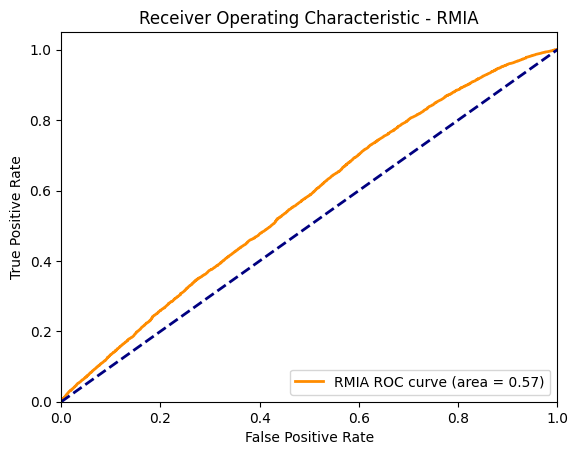

In [15]:

# --- Perform RMIA Attack ---
print("\n--- Computing Probabilities ---")

# P(x | theta_target)
prob_target_members = get_probabilities(target_model, dl_target_eval, device)
prob_target_non_members = get_probabilities(target_model, dl_non_member_eval, device)
prob_target_z = get_probabilities(target_model, dl_pop_eval, device)

# P(x | theta_ref) -> approximates P(x)
prob_ref_members = get_probabilities(ref_model, dl_target_eval, device)
prob_ref_non_members = get_probabilities(ref_model, dl_non_member_eval, device)
prob_ref_z = get_probabilities(ref_model, dl_pop_eval, device)

print("\n--- Calculating RMIA Scores ---")

# Calculate Likelihood Ratios: LR(x) = P(x|Target) / P(x|Ref)
# Adding epsilon to avoid division by zero
epsilon = 1e-10

ratio_members = prob_target_members / (prob_ref_members + epsilon)
ratio_non_members = prob_target_non_members / (prob_ref_non_members + epsilon)
ratio_z = prob_target_z / (prob_ref_z + epsilon)

# RMIA Score(x) = Pr( LR(x) > LR(z) )
# For each x, we calculate what fraction of z samples have a lower ratio.
# This is equivalent to the rank or percentile.

def calculate_rmia_score(ratios_eval, ratios_population):
    scores = []
    # Sort population ratios for binary search (faster) or just broadcasting
    # Using broadcasting for clarity
    ratios_population = np.array(ratios_population)
    for r in ratios_eval:
        # Fraction of population ratios that are strictly smaller than r
        # (or <=, depending on strictness. The paper uses > gamma)
        score = np.mean(r > ratios_population)
        scores.append(score)
    return np.array(scores)

rmia_scores_members = calculate_rmia_score(ratio_members, ratio_z)
rmia_scores_non_members = calculate_rmia_score(ratio_non_members, ratio_z)

# --- Evaluation ---
y_true = np.concatenate([np.ones_like(rmia_scores_members), np.zeros_like(rmia_scores_non_members)])
y_scores = np.concatenate([rmia_scores_members, rmia_scores_non_members])

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

print(f"\nRMIA Attack Results:")
print(f"AUC: {roc_auc:.4f}")

# Plot ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'RMIA ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - RMIA')
plt.legend(loc="lower right")
plt.savefig('rmia_roc_curve.png')
print("ROC curve saved to rmia_roc_curve.png")